In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

from pairs_trading_package.clustering import *

cwd = os.getcwd()

np.set_printoptions(threshold=sys.maxsize)

In [3]:

from pairs_trading_package.pairs_trading_backtester import (
    SeriesAnalyser, DataProcessor, MPSeriesAnalyser, MPTrader, Trader
)
data_processor = DataProcessor()

# load etf metadata
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='../data_folder/original/commodity_ETFs_long_updated.xlsx')

# load intraday prices (5minute interval)
df_prices = pd.read_pickle('../data_folder/original/commodity_ETFs_from_2014_complete.pickle')

SPLIT_IDX = 1

# train split, test split, train_val_split
splits = [ 
    [('01-01-2012', '31-12-2014'), ('01-01-2015', '31-12-2015'), '2014-01-01'],
    [('01-01-2013', '31-12-2015'), ('01-01-2016', '31-12-2016'), '2015-01-01'],
    [('01-01-2014', '31-12-2016'), ('01-01-2017', '31-12-2017'), '2016-01-01'] 
]

# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            splits[SPLIT_IDX][0],
                                                            splits[SPLIT_IDX][1],
                                                            remove_nan=True)
df_returns = data_processor.get_return_series(df_prices_train)

del df_prices

Total of 116 tickers
Total of 105 tickers after removing tickers with Nan values


In [4]:
# Convert string categorical set describing asset sectors/segments to integer.
enc = OrdinalEncoder()

sector_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_returns.columns)]['Sector']

enc.fit(sector_data_df.astype(str).values.reshape(-1, 1))

sector_ground_truth = enc.transform(sector_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)


segment_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_returns.columns)]['Segment']

enc.fit(segment_data_df.astype(str).values.reshape(-1, 1))

segment_ground_truth = enc.transform(segment_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)

# Main Experiment

In [5]:
series_analyser = SeriesAnalyser()

feature_df, explained_variance = series_analyser.apply_PCA(25, df_returns, ignore_first_eigenvector=False)

spectral_algo_args_template = {'n_clusters': range(3, len(feature_df), 1), 'affinity':['nearest_neighbors'], 'eigen_tol': [1e-5]}

kmeans_algo_args_template = {'init':['k-means++'], 'n_clusters': range(3, len(feature_df), 1), 'n_init': [4]}

# ['euclidean', 'manhattan', 'cosine']
single_algo_args_template = {'n_clusters': range(3, len(feature_df), 1), 'linkage': ['single'], 'affinity': ['cosine']}

average_algo_args_template = {'n_clusters': range(3, len(feature_df), 1), 'linkage': ['average'], 'affinity': ['manhattan']}

complete_algo_args_template = {'n_clusters': range(3, len(feature_df), 1), 'linkage': ['complete'], 'affinity': ['cosine']}

# ['euclidean', 'manhattan', 'cosine']
optics_algo_args_template = {'min_samples': range(2, 7), 'metric': ['manhattan']}

internal_algo_results = run_clustering_evaluation(feature_df, {'spectral':  permute_params(spectral_algo_args_template)}, [])

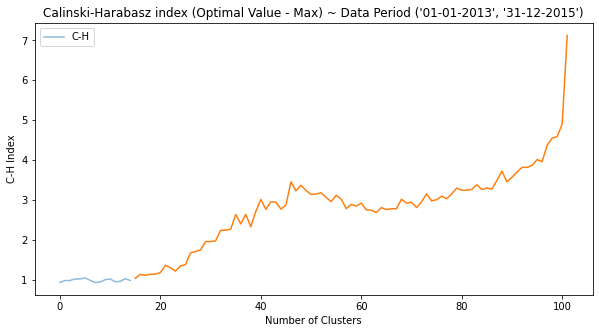

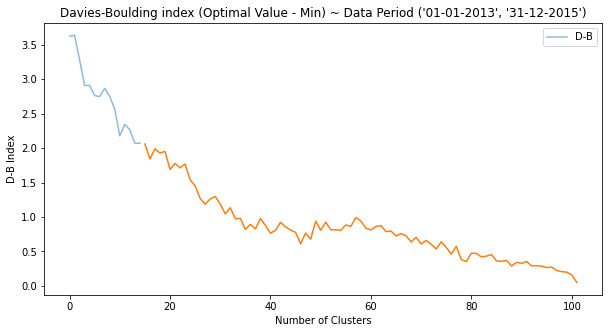

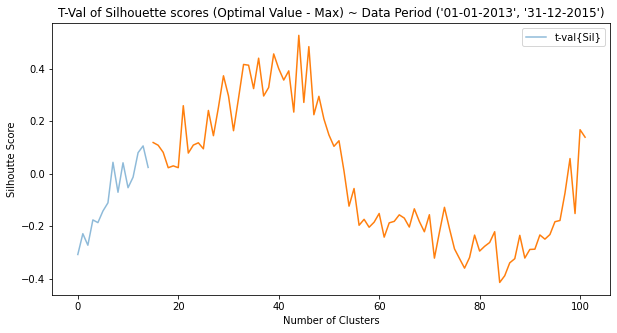

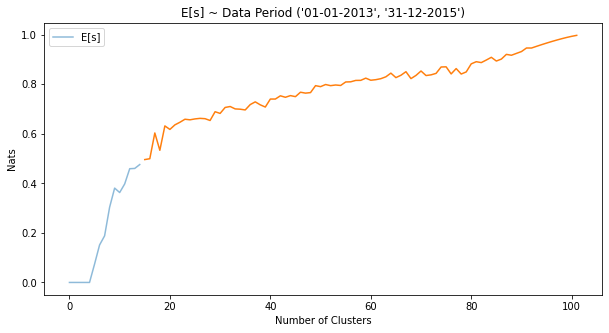

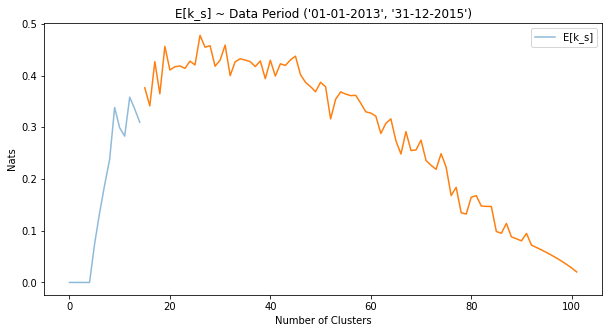

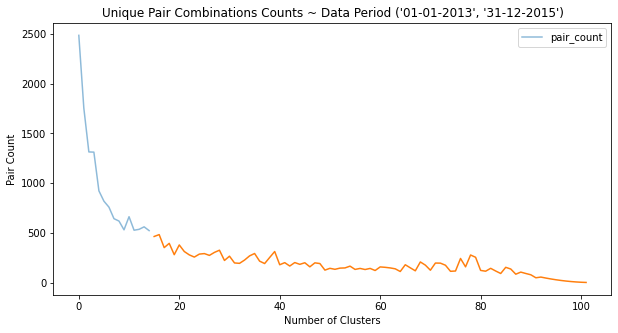

In [7]:
plot_internal_clustering_metrics(internal_algo_results, dict({'pca_comp': 10, 'period': splits[SPLIT_IDX][0]}), False, highlight_excessive_pair_counts=True)

# Per Period Financial Performance Results Generation

In [131]:
cluster_scores = [{'split_idx': 0, 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 34},
                  {'split_idx': 0, 'clust_algo': 'spectral', 'distance_measure': 'nearest_neighbors', 'n_clusters': 38},
                  
                  {'split_idx': 0, 'clust_algo': 'single', 'distance_measure': 'euclidean', 'n_clusters': 62},
                  {'split_idx': 0, 'clust_algo': 'single', 'distance_measure': 'manhattan', 'n_clusters': 62},
                  {'split_idx': 0, 'clust_algo': 'single', 'distance_measure': 'cosine', 'n_clusters': 84},
                  
                  {'split_idx': 0, 'clust_algo': 'average', 'distance_measure': 'euclidean', 'n_clusters': 42},
                  {'split_idx': 0, 'clust_algo': 'average', 'distance_measure': 'manhattan', 'n_clusters': 44},
                  {'split_idx': 0, 'clust_algo': 'average', 'distance_measure': 'cosine', 'n_clusters': 84},
                  
                  {'split_idx': 0, 'clust_algo': 'complete', 'distance_measure': 'euclidean', 'n_clusters': 42},
                  {'split_idx': 0, 'clust_algo': 'complete', 'distance_measure': 'manhattan', 'n_clusters': 62},
                  {'split_idx': 0, 'clust_algo': 'complete', 'distance_measure': 'cosine', 'n_clusters': 30}, 
                 
                  {'split_idx': 0, 'clust_algo': 'optics', 'distance_measure': 'cosine', 'n_clusters': 4},
                  {'split_idx': 0, 'clust_algo': 'optics', 'distance_measure': 'euclidean', 'n_clusters': 2},
                  {'split_idx': 0, 'clust_algo': 'optics', 'distance_measure': 'manhattan', 'n_clusters': 2},
                  
                  ###

                  {'split_idx': 1, 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 40},
                  {'split_idx': 1, 'clust_algo': 'spectral', 'distance_measure': 'nearest_neighbors', 'n_clusters': 42},
                  
                  {'split_idx': 1, 'clust_algo': 'single', 'distance_measure': 'euclidean', 'n_clusters': 72},
                  {'split_idx': 1, 'clust_algo': 'single', 'distance_measure': 'manhattan', 'n_clusters': 68},
                  {'split_idx': 1, 'clust_algo': 'single', 'distance_measure': 'cosine', 'n_clusters': 98},
                  
                  {'split_idx': 1, 'clust_algo': 'average', 'distance_measure': 'euclidean', 'n_clusters': 44},
                  {'split_idx': 1, 'clust_algo': 'average', 'distance_measure': 'manhattan', 'n_clusters': 98},
                  {'split_idx': 1, 'clust_algo': 'average', 'distance_measure': 'cosine', 'n_clusters': 98},
                  
                  {'split_idx': 1, 'clust_algo': 'complete', 'distance_measure': 'euclidean', 'n_clusters': 56},
                  {'split_idx': 1, 'clust_algo': 'complete', 'distance_measure': 'manhattan', 'n_clusters': 58},
                  {'split_idx': 1, 'clust_algo': 'complete', 'distance_measure': 'cosine', 'n_clusters': 98}, 
                 
                  {'split_idx': 1, 'clust_algo': 'optics', 'distance_measure': 'cosine', 'n_clusters': 4},
                  {'split_idx': 1, 'clust_algo': 'optics', 'distance_measure': 'euclidean', 'n_clusters': 3},
                  {'split_idx': 1, 'clust_algo': 'optics', 'distance_measure': 'manhattan', 'n_clusters': 2},
                  
                  ###
                  
                  {'split_idx': 2, 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 46},
                  {'split_idx': 2, 'clust_algo': 'spectral', 'distance_measure': 'nearest_neighbors', 'n_clusters': 42},
                  
                  {'split_idx': 2, 'clust_algo': 'single', 'distance_measure': 'euclidean', 'n_clusters': 66},
                  {'split_idx': 2, 'clust_algo': 'single', 'distance_measure': 'manhattan', 'n_clusters': 64},
                  {'split_idx': 2, 'clust_algo': 'single', 'distance_measure': 'cosine', 'n_clusters': 110},
                  
                  {'split_idx': 2, 'clust_algo': 'average', 'distance_measure': 'euclidean', 'n_clusters': 60},
                  {'split_idx': 2, 'clust_algo': 'average', 'distance_measure': 'manhattan', 'n_clusters': 62},
                  {'split_idx': 2, 'clust_algo': 'average', 'distance_measure': 'cosine', 'n_clusters': 100},
                  
                  {'split_idx': 2, 'clust_algo': 'complete', 'distance_measure': 'euclidean', 'n_clusters': 64},
                  {'split_idx': 2, 'clust_algo': 'complete', 'distance_measure': 'manhattan', 'n_clusters': 44},
                  {'split_idx': 2, 'clust_algo': 'complete', 'distance_measure': 'cosine', 'n_clusters': 40}, 
                 
                  {'split_idx': 2, 'clust_algo': 'optics', 'distance_measure': 'cosine', 'n_clusters': 4},
                  {'split_idx': 2, 'clust_algo': 'optics', 'distance_measure': 'euclidean', 'n_clusters': 4},
                  {'split_idx': 2, 'clust_algo': 'optics', 'distance_measure': 'manhattan', 'n_clusters': 3}]


In [103]:
import pandas as pd
import numpy as np

meta_data_files = ['../data_folder/experiment_1/backtest_results/af6ebf5a064c26181583dd53195b9cf4.csv', 
                   '../data_folder/experiment_1/backtest_results/da294a6e57c7f5315d5b7026955becf6.csv', 
                   '../data_folder/experiment_1/backtest_results/002a0d2dbde527ab7fb1c3fb56069dd9.csv']


meta_data_splits = [ 
    ['2012 - 2016'],
    ['2013 - 2017'],
    ['2014 - 2018'] 
]

In [132]:
clust_data_list = []

for first_pass_idx in range(0, 14):
    for second_pass_idx in [0, 14, 28]:
        
        cs = cluster_scores[first_pass_idx+second_pass_idx]
        
        current_clust_data = {}
        current_clust_data['split_idx'] = meta_data_splits[cs['split_idx']][0] 
        current_clust_data['clust_algo'] = cs['clust_algo']
        current_clust_data['distance_measure'] = cs['distance_measure']

        working_df = pd.read_csv(meta_data_files[cs['split_idx']])
        working_df.drop(['Unnamed: 0'], axis=1, inplace=True)
        working_df.reset_index(drop=True, inplace=True)
        working_df.drop_duplicates(inplace=True)
        working_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        working_df.dropna(inplace=True)

        first_pass_df = working_df[working_df['clust_algo'] == cs['clust_algo']]
        second_pass_df = first_pass_df[first_pass_df['distance_measure'] == cs['distance_measure']]

        cols_to_select = ['annual_sharpe_ratio_iid_insample', 'avg_total_roi_insample', 'max_dd_insample', 
                                                                            'annual_sharpe_ratio_iid_oosample', 'avg_total_roi_oosample', 'max_dd_oosample']
        third_pass_df = second_pass_df[second_pass_df['n_clusters'] == cs['n_clusters']].loc[:, cols_to_select]


        if len(third_pass_df) == 0: 
            nearest_available = second_pass_df['n_clusters'].values[np.argmin(np.abs(second_pass_df['n_clusters'].values - cs['n_clusters']))]

            third_pass_df = second_pass_df[second_pass_df['n_clusters'] == nearest_available].loc[:, cols_to_select]
            cluster_scores[first_pass_idx+second_pass_idx]['n_clusters'] = nearest_available

        third_pass_df_means = np.around(third_pass_df.mean(), 2) 
        third_pass_df_stds = np.around(third_pass_df.std(), 2)

        for col_to_select in cols_to_select:
            current_clust_data[col_to_select] = str(third_pass_df_means[col_to_select]) + ' (' + str(third_pass_df_stds[col_to_select]) + ')'

        clust_data_list.append(current_clust_data)

In [139]:
pd.DataFrame(clust_data_list)#.to_csv('./pretty_results/per_period_performance_table.csv')

,split_idx,clust_algo,distance_measure,annual_sharpe_ratio_iid_insample,avg_total_roi_insample,max_dd_insample,annual_sharpe_ratio_iid_oosample,avg_total_roi_oosample,max_dd_oosample
0,2012 - 2016,kmeans,euclidean,3.87 (1.32),6.7 (2.3),-0.87 (0.14),2.77 (0.21),5.34 (1.9),-1.09 (0.44)
1,2013 - 2017,kmeans,euclidean,4.86 (1.7),12.97 (0.79),-0.93 (0.51),5.48 (1.2),16.5 (3.14),-1.44 (0.7)
2,2014 - 2018,kmeans,euclidean,5.61 (0.87),11.39 (1.31),-0.89 (0.05),3.77 (0.6),5.7 (0.9),-0.71 (0.09)
3,2012 - 2016,spectral,nearest_neighbors,4.69 (0.68),12.96 (3.82),-1.1 (0.42),2.4 (0.8),7.02 (2.95),-2.71 (0.74)
4,2013 - 2017,spectral,nearest_neighbors,4.7 (0.73),12.33 (1.28),-1.13 (0.42),4.86 (1.32),12.04 (2.49),-1.13 (0.29)
5,2014 - 2018,spectral,nearest_neighbors,4.18 (0.52),24.72 (17.42),-3.17 (2.34),2.65 (0.72),6.31 (0.78),-0.91 (0.37)
6,2012 - 2016,single,euclidean,4.37 (0.0),6.51 (0.0),-0.47 (0.0),3.85 (0.0),8.5 (0.0),-1.43 (0.0)
7,2013 - 2017,single,euclidean,5.01 (0.0),8.03 (0.0),-0.64 (0.0),2.97 (0.0),6.88 (0.0),-1.74 (0.0)
8,2014 - 2018,single,euclidean,2.01 (0.44),5.44 (0.46),-2.05 (0.44),2.32 (0.81),4.07 (1.02),-1.02 (0.34)
9,2012 - 2016,single,manhattan,3.54 (0.0),5.43 (0.0),-0.69 (0.0),3.41 (0.0),7.23 (0.0),-2.23 (0.0)


In [134]:

def get_merged_results_as_dataframe(file_list):

    results_per_period = []

    for file in file_list:
        backtest_results_ae_df = pd.read_csv(meta_data_files[file['split_idx']])

        working_example_df_ae = backtest_results_ae_df[backtest_results_ae_df['clust_algo'] == file['clust_algo']]
        working_example_df_ae = working_example_df_ae[working_example_df_ae['distance_measure'] == file['distance_measure']]
        working_example_df_ae = working_example_df_ae[working_example_df_ae['n_clusters'] == file['n_clusters']]

        results_per_period.append(working_example_df_ae)

    merged_results = []

    for period_zero_sample in results_per_period[0].iterrows():
    #     find equivalent from results_per_period[1]

        working_period_one_df_ae = results_per_period[1].dropna()
        working_period_one_df_ae = working_period_one_df_ae[working_period_one_df_ae['seed'] == period_zero_sample[1]['seed']]

        if len(working_period_one_df_ae) != 0:
            working_period_one_df_ae = working_period_one_df_ae.dropna().sample(1)
        else: 
            working_period_one_df_ae = results_per_period[1].dropna().sample(1)

    #     find equivalent from results_per_period[2]

        working_period_two_df_ae = results_per_period[2].dropna()
        working_period_two_df_ae = working_period_two_df_ae[working_period_two_df_ae['seed'] == period_zero_sample[1]['seed']].dropna()

        if len(working_period_two_df_ae) != 0:
            working_period_two_df_ae = working_period_two_df_ae.dropna().sample(1)
        else: 
            working_period_two_df_ae = results_per_period[2].dropna().sample(1)

        merged_results.append([period_zero_sample[1]['clust_algo'], period_zero_sample[1]['seed'],

                               period_zero_sample[1]['portfolio_returns_saved_file_insample'], 
                               period_zero_sample[1]['portfolio_returns_saved_file_oosample'],

                               working_period_one_df_ae['portfolio_returns_saved_file_insample'].values[0], 
                               working_period_one_df_ae['portfolio_returns_saved_file_oosample'].values[0],

                               working_period_two_df_ae['portfolio_returns_saved_file_insample'].values[0], 
                               working_period_two_df_ae['portfolio_returns_saved_file_oosample'].values[0],
                              ])

    merged_results_df = pd.DataFrame(merged_results, columns=['clust_algo', 'rand_seed', 
                           'period_zero_returns_file_insample', 'period_zero_returns_file_oosample',
                           'period_one_returns_file_insample', 'period_one_returns_file_oosample',
                           'period_two_returns_file_insample', 'period_two_returns_file_oosample',
                          ])

    return merged_results_df

def sample_n_times(N, file_list):
    sampled_dfs = []
    
    for _ in range(N):
        sample_df = get_merged_results_as_dataframe(file_list)
        sampled_dfs.append(sample_df)
        
    return pd.concat(sampled_dfs)

def get_collated_returns_as_dataframe(merged_results_df, sample_period='oosample'):
    collated_dfs = []

    for full_period_sample in merged_results_df.iterrows():
        per_zero = pd.read_csv('../data_folder/results_visualizations/backtest_results/return_series/' + full_period_sample[1]['period_zero_returns_file_' + sample_period])
        per_one = pd.read_csv('../data_folder/results_visualizations/backtest_results/return_series/' + full_period_sample[1]['period_one_returns_file_' + sample_period])
        per_two = pd.read_csv('../data_folder/results_visualizations/backtest_results/return_series/' + full_period_sample[1]['period_two_returns_file_' + sample_period])

        collated_df = pd.concat([per_zero, per_one, per_two])
        collated_df['Date'] = pd.to_datetime(collated_df['Date'])
        collated_df.set_index('Date', inplace=True, drop=True)

        collated_dfs.append(collated_df)
        
    return collated_dfs


def get_sharpe_distribution_from_collated_returns(collated_dfs, rf_rate=0.01):
    
    annualized_ret = pd.concat(collated_dfs, axis=1).mean()*252
    vol = pd.concat(collated_dfs, axis=1).std()*np.sqrt(252)

    rf_daily = (1+rf_rate)**(1/252)-1

    sharpe_ratio_assuming_iid = (annualized_ret-rf_daily) /vol
    
    return sharpe_ratio_assuming_iid


def get_mdd_distribution_from_collated_returns(collated_dfs, rf_rate=0.01):
    trader_obj = Trader()
    
    cum_rets = pd.concat(collated_dfs, axis=1).cumsum()

    mdd_dist = []
    for cr in range(len(cum_rets.columns)):
        mdd_dist.append( trader_obj.calculate_maximum_drawdown(1+cum_rets.iloc[:, cr]*1, False)[0] )
    
    return np.array(mdd_dist)

In [135]:
clust_data_list_full_period = []

for first_pass_idx in range(0, 14):
    
    intermediate_cluster_scores_array = []
    
    for second_pass_idx in [0, 14, 28]:
        cs = cluster_scores[first_pass_idx+second_pass_idx]
        intermediate_cluster_scores_array.append(cs)
        
    current_clust_data_full = {}
    current_clust_data_full['clust_algo'] = cs['clust_algo']
    current_clust_data_full['distance_measure'] = cs['distance_measure']
        
    merged_results_pca_df = sample_n_times(4, intermediate_cluster_scores_array)
    
    pca_returns_is_collated_df = get_collated_returns_as_dataframe(merged_results_pca_df, 'insample')
    pca_returns_oos_collated_df = get_collated_returns_as_dataframe(merged_results_pca_df, 'oosample')
    
    pca_is_cumrets_results = pd.concat(pca_returns_is_collated_df, axis=1).mean()*252#.iloc[-1]
    pca_oos_cumrets_results = pd.concat(pca_returns_oos_collated_df, axis=1).mean()*252#.iloc[-1]
    
    current_clust_data_full['insample_roi'] = str(np.round(pca_is_cumrets_results.mean()*100, 2)) + ' (' + str(np.round(pca_is_cumrets_results.std()*100, 2)) + ')'
    current_clust_data_full['oosample_roi'] = str(np.round(pca_oos_cumrets_results.mean()*100, 2)) + ' (' + str(np.round(pca_oos_cumrets_results.std()*100, 2)) + ')'
        
    pca_is_sharpe_results = get_sharpe_distribution_from_collated_returns(pca_returns_is_collated_df)
    pca_oos_sharpe_results = get_sharpe_distribution_from_collated_returns(pca_returns_oos_collated_df)
    
    current_clust_data_full['insample_sharpe'] = str(np.round(pca_is_sharpe_results.mean(), 2)) + ' (' + str(np.round(pca_is_sharpe_results.std(), 2)) + ')'
    current_clust_data_full['oosample_sharpe'] = str(np.round(pca_oos_sharpe_results.mean(), 2)) + ' (' + str(np.round(pca_oos_sharpe_results.std(), 2)) + ')'
    
    pca_is_mdd_results = get_mdd_distribution_from_collated_returns(pca_returns_is_collated_df)
    pca_oos_mdd_results = get_mdd_distribution_from_collated_returns(pca_returns_oos_collated_df)
    
    current_clust_data_full['insample_mdd'] = str(np.round(pca_is_mdd_results.mean(), 2)) + ' (' + str(np.round(pca_is_mdd_results.std(), 2)) + ')'
    current_clust_data_full['oosample_mdd'] = str(np.round(pca_oos_mdd_results.mean(), 2)) + ' (' + str(np.round(pca_oos_mdd_results.std(), 2)) + ')'
    
    clust_data_list_full_period.append(current_clust_data_full)

In [137]:
pd.DataFrame(clust_data_list_full_period).to_csv('./pretty_results/full_period_performance_table.csv')